In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from PIL import Image
from warnings import filterwarnings
filterwarnings('ignore')

In [4]:
# Make a Dataset
batch_size = 32
image_size = 256
dataset_path = '/Users/bhupesh/Downloads/potato-2/potato' 
dataset = keras.preprocessing.image_dataset_from_directory(directory=dataset_path,
                                                           batch_size=batch_size,
                                                           image_size=(image_size, image_size),
                                                           shuffle=True)
dataset

Found 2152 files belonging to 3 classes.


2025-06-12 18:54:30.678036: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4
2025-06-12 18:54:30.678065: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-06-12 18:54:30.678070: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-06-12 18:54:30.678090: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-06-12 18:54:30.678103: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [5]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [6]:
len(dataset)

68

In [7]:
93 * batch_size

2976

In [8]:
# No of images in last badge

32 - (2976 - 2948)

4

In [9]:
def train_validation_test_split(dataset, train_size=0.8, validation_size=0.1, test_size=0.1, shuffle=True, shuffle_size=10000):

    dataset_batch_count = len(dataset)
    train_batch_count = int(dataset_batch_count * train_size)
    validation_test_batch_count = int(dataset_batch_count * validation_size)

    if shuffle:
        dataset = dataset.shuffle(buffer_size=shuffle_size)

    train_ds = dataset.take(train_batch_count)
    validation_ds = dataset.skip(train_batch_count).take(validation_test_batch_count)
    test_ds = dataset.skip(train_batch_count).skip(validation_test_batch_count)

    return train_ds, validation_ds, test_ds

In [10]:
train_ds, validation_ds, test_ds = train_validation_test_split(dataset)
len(train_ds), len(validation_ds), len(test_ds)

(54, 6, 8)

(256, 256, 3)
[[[149. 142. 149.]
  [159. 152. 159.]
  [160. 153. 160.]
  ...
  [193. 188. 194.]
  [181. 176. 182.]
  [188. 183. 189.]]

 [[148. 141. 148.]
  [159. 152. 159.]
  [168. 161. 168.]
  ...
  [192. 187. 193.]
  [187. 182. 188.]
  [202. 197. 203.]]

 [[151. 144. 151.]
  [151. 144. 151.]
  [156. 149. 156.]
  ...
  [185. 180. 186.]
  [187. 182. 188.]
  [208. 203. 209.]]

 ...

 [[124. 124. 134.]
  [128. 128. 138.]
  [119. 119. 129.]
  ...
  [152. 151. 165.]
  [184. 183. 197.]
  [190. 189. 203.]]

 [[149. 149. 161.]
  [147. 147. 159.]
  [129. 129. 141.]
  ...
  [144. 143. 159.]
  [159. 158. 174.]
  [164. 163. 179.]]

 [[153. 153. 165.]
  [146. 146. 158.]
  [148. 148. 160.]
  ...
  [166. 165. 183.]
  [165. 164. 182.]
  [159. 158. 176.]]]

(32,)
0



2025-06-12 18:54:37.222673: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


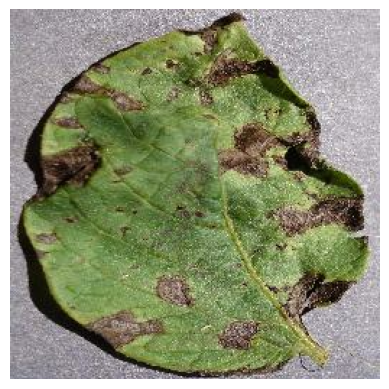

In [11]:
for image_batch, label_batch in train_ds.take(1):
    print(image_batch.numpy()[0].shape)
    print(image_batch.numpy()[0])
    print()

    print(label_batch.numpy().shape)
    print(label_batch.numpy()[0])
    print()

    plt.imshow(image_batch.numpy()[0].astype('uint8'))
    plt.axis('off')

In [12]:
train_ds

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [13]:
# Build Data Pipeline

train_ds = train_ds.cache().shuffle(buffer_size=1000).prefetch(tf.data.AUTOTUNE)
validation_ds = validation_ds.cache().shuffle(buffer_size=1000).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(buffer_size=1000).prefetch(tf.data.AUTOTUNE)

In [14]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [15]:
channel = 3  # RGB
input_shape = (batch_size, image_size, image_size, channel)
target = 3  # len(class_names)

input_shape

(32, 256, 256, 3)

In [16]:
# Image Data Preprocessing

preprocessing = keras.Sequential([
                    keras.layers.Resizing(height=image_size, width=image_size),
                    keras.layers.Rescaling(scale=1./255),
                    keras.layers.RandomFlip(mode='horizontal_and_vertical'),
                    keras.layers.RandomRotation(factor=0.2)
                ])
preprocessing

<Sequential name=sequential, built=False>

In [17]:
# Build CNN Architecture

model = keras.Sequential([
            # CNN
            preprocessing,
            keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=input_shape),
            keras.layers.MaxPooling2D(pool_size=(2, 2)),

            keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
            keras.layers.MaxPooling2D(pool_size=(2, 2)),
            keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
            keras.layers.MaxPooling2D(pool_size=(2, 2)),
            keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
            keras.layers.MaxPooling2D(pool_size=(2, 2)),
            keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
            keras.layers.MaxPooling2D(pool_size=(2, 2)),
            keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
            keras.layers.MaxPooling2D(pool_size=(2, 2)),

            # ANN
            keras.layers.Flatten(),
            keras.layers.Dense(units=64, activation='relu'),
            keras.layers.Dense(units=target, activation='softmax')
        ])
model

<Sequential name=sequential_1, built=False>

In [18]:
model.build(input_shape)
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [56]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model

<Sequential name=sequential_1, built=True>

In [20]:
history = model.fit(train_ds,
                    batch_size=batch_size,
                    epochs=10,
                    verbose=1,
                    validation_data = validation_ds)
history

Epoch 1/10


2025-06-12 18:54:53.107447: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2025-06-12 18:54:53.115076: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


54/54 ━━━━━━━━━━━━━━━━━━━━ 20s 231ms/step - accuracy: 0.4750 - loss: 0.9426 - val_accuracy: 0.6771 - val_loss: 0.8177
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 176ms/step - accuracy: 0.6145 - loss: 0.7780 - val_accuracy: 0.6771 - val_loss: 0.6366
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 179ms/step - accuracy: 0.7313 - loss: 0.5475 - val_accuracy: 0.8385 - val_loss: 0.3626
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 184ms/step - accuracy: 0.8220 - loss: 0.4227 - val_accuracy: 0.8229 - val_loss: 0.3693
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 190ms/step - accuracy: 0.8750 - loss: 0.3024 - val_accuracy: 0.9010 - val_loss: 0.2614
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 9s 174ms/step - accuracy: 0.9029 - loss: 0.2403 - val_accuracy: 0.9583 - val_loss: 0.1288
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 185ms/step - accuracy: 0.9228 - loss: 0.1910 - val_accuracy: 0.9219 - val_loss: 0.1603
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 12s 216ms/step - accuracy: 0.9256 - loss: 0.1836 - val_accuracy: 0.9583

In [26]:
model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.9677 - loss: 0.0604


[0.05217273160815239, 0.98046875]

In [27]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 54}

In [28]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [30]:
acc[0:5]

[0.9403935074806213,
 0.9577546119689941,
 0.9623842835426331,
 0.9716435074806213,
 0.9756944179534912]

In [31]:
len(acc), len(val_acc), len(loss), len(val_loss)

(10, 10, 10, 10)

In [34]:
model.save('model_potato.h5')

Text(0.5, 1.0, 'Training vs Validation Loss')

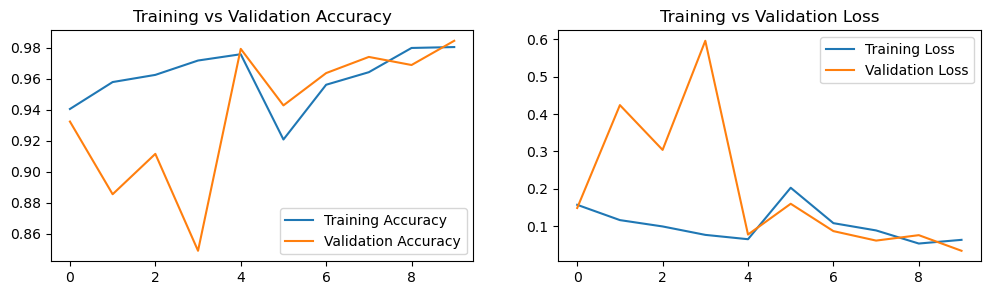

In [35]:
plt.figure(figsize=(12, 3))

plt.subplot(1, 2, 1)
plt.plot(range(len(acc)), acc, label='Training Accuracy')
plt.plot(range(len(val_acc)), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training vs Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(len(loss)), loss, label='Training Loss')
plt.plot(range(len(val_loss)), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training vs Validation Loss')

In [36]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [37]:
def prediction(image_path, class_names = dataset.class_names):

    img = Image.open(image_path).resize((256,256))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)

    model = tf.keras.models.load_model('model.h5')
    prediction = model.predict(img_array)

    predicted_class = class_names[np.argmax(prediction)]
    confidence = round(np.max(prediction)*100, 2)

    print(f'Predicted Class : {predicted_class}')
    print(f'Confident : {confidence}%')
    print('')
    plt.imshow(img)
    plt.axis('off')


In [55]:
# Ensure the file exists at the specified path
image_path = '/Users/bhupesh/Downloads/potato-2/potato/Potato___Early_blight'

if not os.path.exists(image_path):
	raise FileNotFoundError(f"No such file or directory: '{image_path}'")

prediction(image_path=image_path)
# Generate a random image from the dataset for prediction
for image_batch, label_batch in dataset.take(1):
    random_image = image_batch.numpy()[np.random.randint(0, batch_size)]
    plt.imshow(random_image.astype('uint8'))
    plt.axis('off')
    plt.show()

    # Preprocess the random image for prediction
    random_image_array = np.expand_dims(random_image, axis=0)
    prediction = model.predict(random_image_array)

    predicted_class = class_names[np.argmax(prediction)]
    confidence = round(np.max(prediction) * 100, 2)

    print(f'Predicted Class : {predicted_class}')
    print(f'Confidence : {confidence}%')

TypeError: 'numpy.ndarray' object is not callable